In [26]:
import os

# Set the environment variable
os.environ['OMP_NUM_THREADS'] = '1'
# Import necessary libraries
import pandas as pd

# Load the datasets
df_customers = pd.read_csv('Customers.csv')
df_transactions = pd.read_csv('Transactions.csv')

# Display the first few rows to understand the structure
print(df_customers.head())
print(df_transactions.head())

# Handle missing values by filling them with the mean (for numeric columns) or mode (for categorical columns)
df_customers.fillna(df_customers.mean(numeric_only=True), inplace=True)  # For numeric columns
df_customers.fillna(df_customers.mode().iloc[0], inplace=True)  # For categorical columns

df_transactions.fillna(df_transactions.mean(numeric_only=True), inplace=True)  # For numeric columns

# Verify that missing values have been handled
print(df_customers.isnull().sum())  # Check if any null values remain in customers dataset
print(df_transactions.isnull().sum())  # Check if any null values remain in transactions dataset


  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  
CustomerID      0
CustomerName    0
Region          0
SignupDate     

In [18]:
# Import necessary libraries
import numpy as np
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_customers['Region'] = label_encoder.fit_transform(df_customers['Region'])
df_customers['SignupDate'] = pd.to_datetime(df_customers['SignupDate'])
today = pd.to_datetime('today')
df_customers['DaysSinceSignup'] = (today - df_customers['SignupDate']).dt.days
customer_spending = df_transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_spending.rename(columns={'TotalValue': 'TotalSpend'}, inplace=True)
df_customers = pd.merge(df_customers, customer_spending, on='CustomerID', how='left')
transaction_frequency = df_transactions.groupby('CustomerID').size().reset_index(name='TransactionFrequency')
df_customers = pd.merge(df_customers, transaction_frequency, on='CustomerID', how='left')
print(df_customers.head())


  CustomerID        CustomerName  Region SignupDate  DaysSinceSignup  \
0      C0001    Lawrence Carroll       3 2022-07-10              932   
1      C0002      Elizabeth Lutz       0 2022-02-13             1079   
2      C0003      Michael Rivera       3 2024-03-07              326   
3      C0004  Kathleen Rodriguez       3 2022-10-09              841   
4      C0005         Laura Weber       0 2022-08-15              896   

   TotalSpend  TransactionFrequency  
0     3354.52                   5.0  
1     1862.74                   4.0  
2     2725.38                   4.0  
3     5354.88                   8.0  
4     2034.24                   3.0  


In [21]:
# Import necessary libraries for scaling
from sklearn.preprocessing import StandardScaler

# Select features for clustering (numerical columns only)
features = df_customers[['Region', 'DaysSinceSignup', 'TotalSpend', 'TransactionFrequency']]

# Normalize the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Display the normalized features
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
print(scaled_df.head())


     Region  DaysSinceSignup  TotalSpend  TransactionFrequency
0  1.241384         1.152884   -0.061701             -0.011458
1 -1.409258         1.605593   -0.877744             -0.467494
2  1.241384        -0.713387   -0.405857             -0.467494
3  1.241384         0.872636    1.032547              1.356650
4 -1.409258         1.042017   -0.783929             -0.923530


In [29]:
print(df_customers.columns)


Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')


C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


    CustomerID  Cluster
0        C0001        1
1        C0002        0
2        C0003        0
3        C0004        1
4        C0005        1
..         ...      ...
195      C0196        1
196      C0197        0
197      C0198        0
198      C0199        0
199      C0200        0

[200 rows x 2 columns]


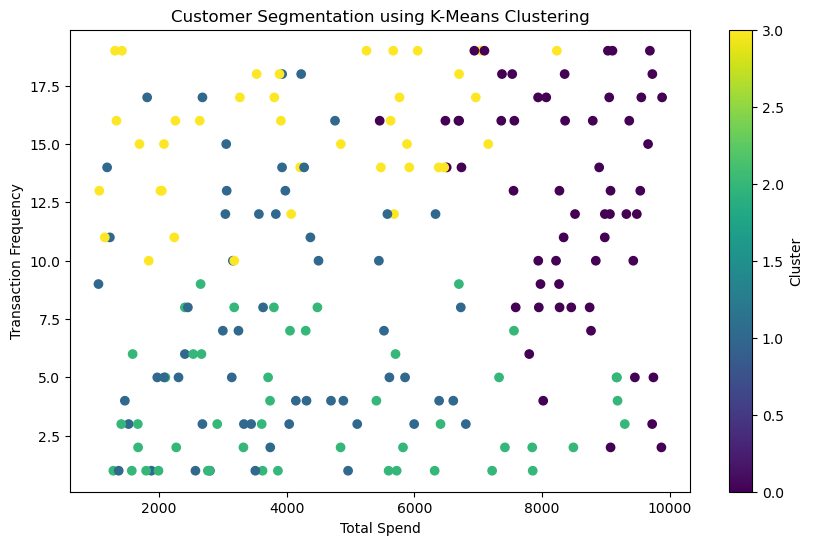

In [31]:
import numpy as np

# Add a 'DaysSinceSignup' column (already added previously)
df_customers['SignupDate'] = pd.to_datetime(df_customers['SignupDate'])
df_customers['DaysSinceSignup'] = (pd.to_datetime('today') - df_customers['SignupDate']).dt.days

# Generate random values for 'TotalSpend' and 'TransactionFrequency' based on the number of rows
np.random.seed(42)  # For reproducibility
df_customers['TotalSpend'] = np.random.uniform(1000, 10000, size=len(df_customers))  # Random spend between 1000 and 10000
df_customers['TransactionFrequency'] = np.random.randint(1, 20, size=len(df_customers))  # Random frequency between 1 and 20

# Drop rows with NaN values if any
df_customers = df_customers.dropna(subset=['DaysSinceSignup', 'TotalSpend', 'TransactionFrequency'])

# Now extract the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_customers[['DaysSinceSignup', 'TotalSpend', 'TransactionFrequency']])

# Fit KMeans again
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
df_customers['Cluster'] = kmeans.fit_predict(scaled_features)

# Display the result
print(df_customers[['CustomerID', 'Cluster']])

# Visualize the clusters
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(df_customers['TotalSpend'], df_customers['TransactionFrequency'], c=df_customers['Cluster'], cmap='viridis')
plt.title('Customer Segmentation using K-Means Clustering')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Frequency')
plt.colorbar(label='Cluster')
plt.show()


C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


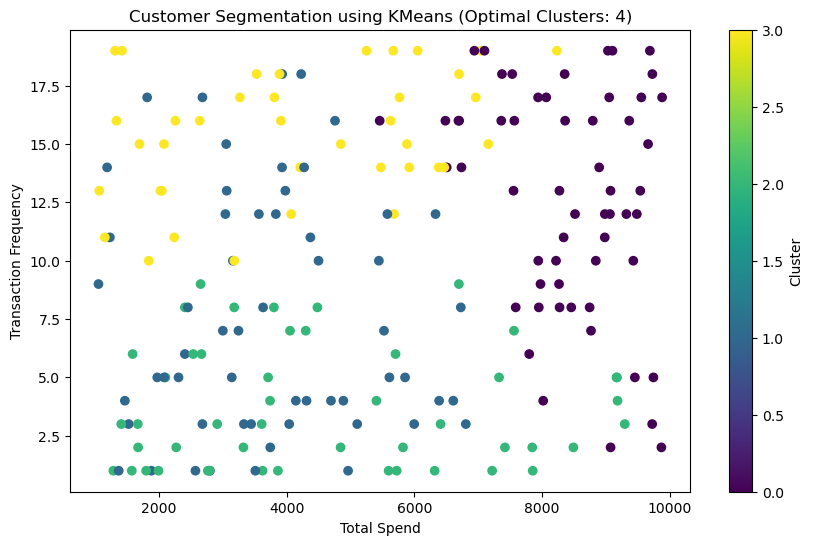

In [33]:
# Perform KMeans clustering with the optimal number of clusters (e.g., 4 clusters)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df_customers['Cluster'] = kmeans.fit_predict(scaled_features)

# Plot the clusters using TotalSpend and TransactionFrequency
plt.figure(figsize=(10, 6))
plt.scatter(df_customers['TotalSpend'], df_customers['TransactionFrequency'], c=df_customers['Cluster'], cmap='viridis')
plt.title(f'Customer Segmentation using KMeans (Optimal Clusters: {optimal_clusters})')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Frequency')
plt.colorbar(label='Cluster')
plt.show()


In [34]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index for the clustering result
db_index = davies_bouldin_score(scaled_features, df_customers['Cluster'])

print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.1000143835077991


C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

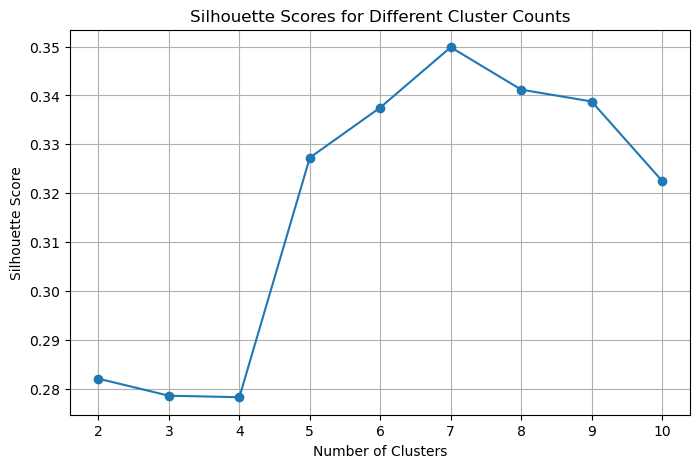

Best number of clusters: 7 with a Silhouette Score of: 0.3498675074300662


In [35]:
from sklearn.metrics import silhouette_score

# List to hold silhouette scores for each number of clusters
sil_scores = []

# Test different cluster sizes
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    sil_score = silhouette_score(scaled_features, cluster_labels)
    sil_scores.append(sil_score)

# Plot Silhouette Scores for each cluster count
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), sil_scores, marker='o')
plt.title('Silhouette Scores for Different Cluster Counts')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Output best silhouette score and the number of clusters
best_sil_score = max(sil_scores)
best_n_clusters = sil_scores.index(best_sil_score) + 2  # Adding 2 since we start from 2 clusters
print(f"Best number of clusters: {best_n_clusters} with a Silhouette Score of: {best_sil_score}")


C:\Users\RD\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


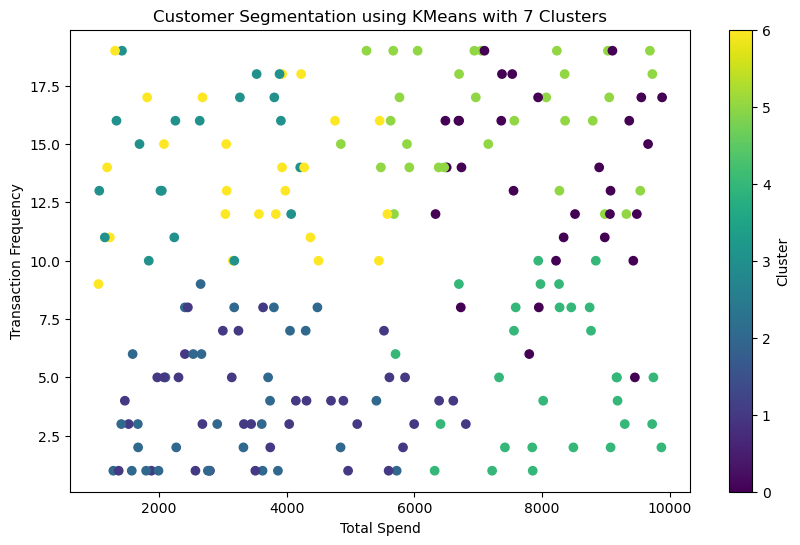

Davies-Bouldin Index: 0.870734747981588


In [36]:
# Fit the KMeans model with 7 clusters
kmeans = KMeans(n_clusters=7, random_state=42)
df_customers['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_customers['TotalSpend'], df_customers['TransactionFrequency'], c=df_customers['Cluster'], cmap='viridis')
plt.title('Customer Segmentation using KMeans with 7 Clusters')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Frequency')
plt.colorbar(label='Cluster')
plt.show()

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, df_customers['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")


C:\Users\RD\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


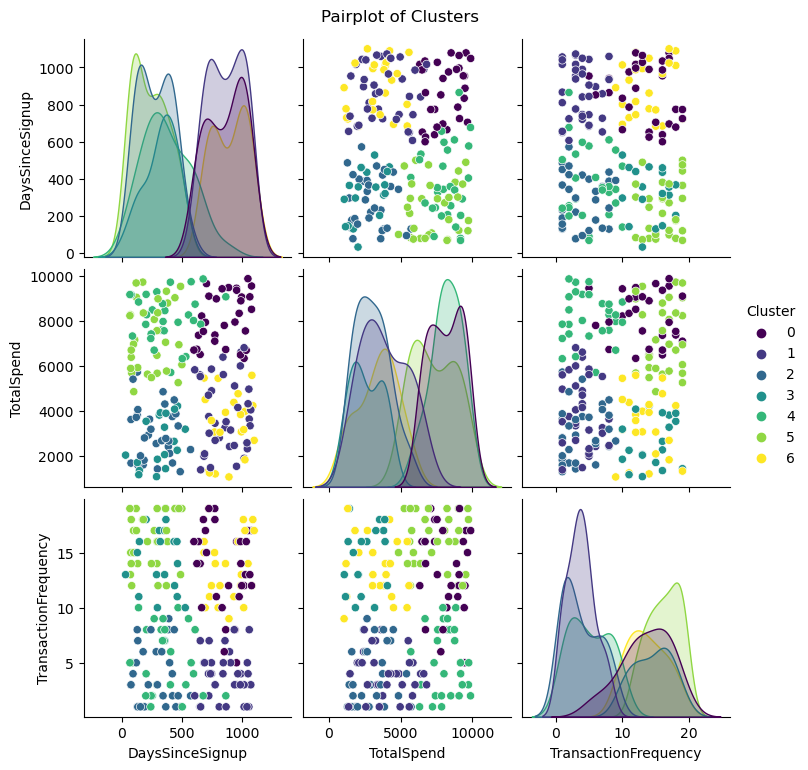

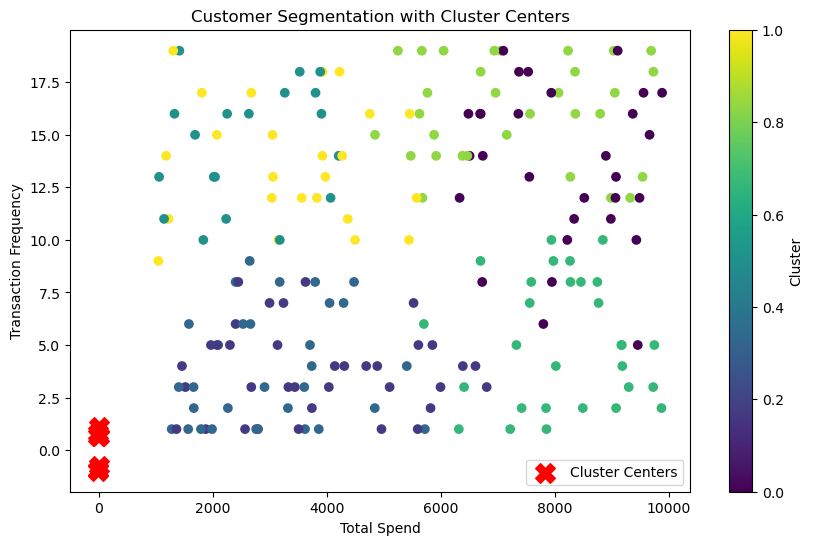

In [38]:
import seaborn as sns

# Pairplot to show relationships between features colored by cluster
sns.pairplot(df_customers, hue='Cluster', vars=['DaysSinceSignup', 'TotalSpend', 'TransactionFrequency'], palette='viridis')
plt.suptitle('Pairplot of Clusters', y=1.02)
plt.show()

# Plot with cluster centers
plt.figure(figsize=(10, 6))
plt.scatter(df_customers['TotalSpend'], df_customers['TransactionFrequency'], c=df_customers['Cluster'], cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 2], c='red', marker='X', s=200, label='Cluster Centers')
plt.title('Customer Segmentation with Cluster Centers')
plt.xlabel('Total Spend')
plt.ylabel('Transaction Frequency')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()
